/Users/gycelect/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


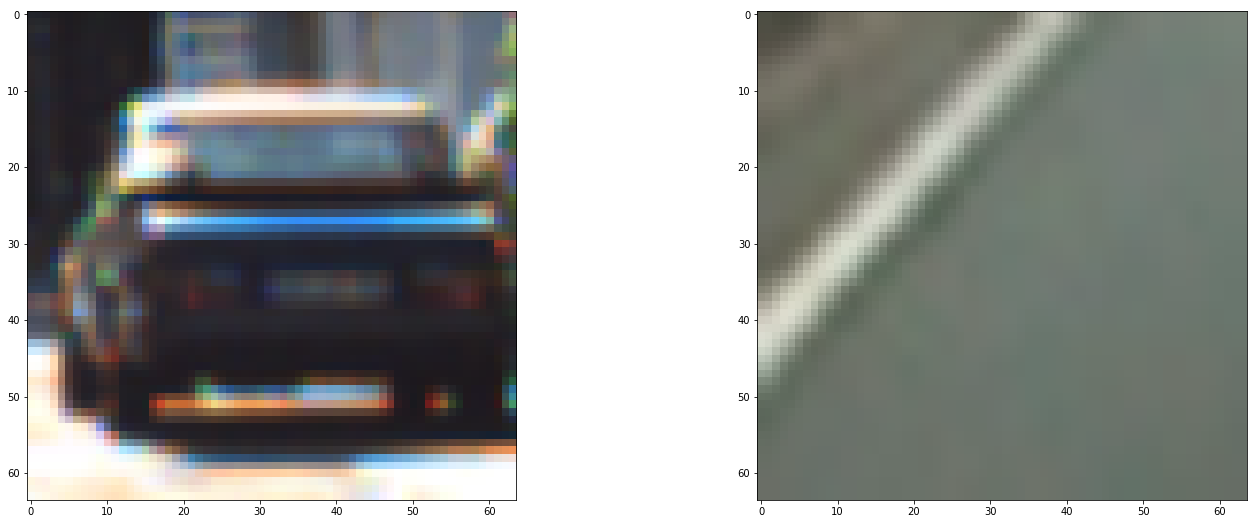

In [1]:
# demo HOG feature 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

car_example = mpimg.imread('vehicles/KITTI_extracted/1.png')
notcar_example = mpimg.imread('non-vehicles/GTI/image12.png')
%matplotlib inline
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(car_example)
ax2.imshow(notcar_example)



/Users/gycelect/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


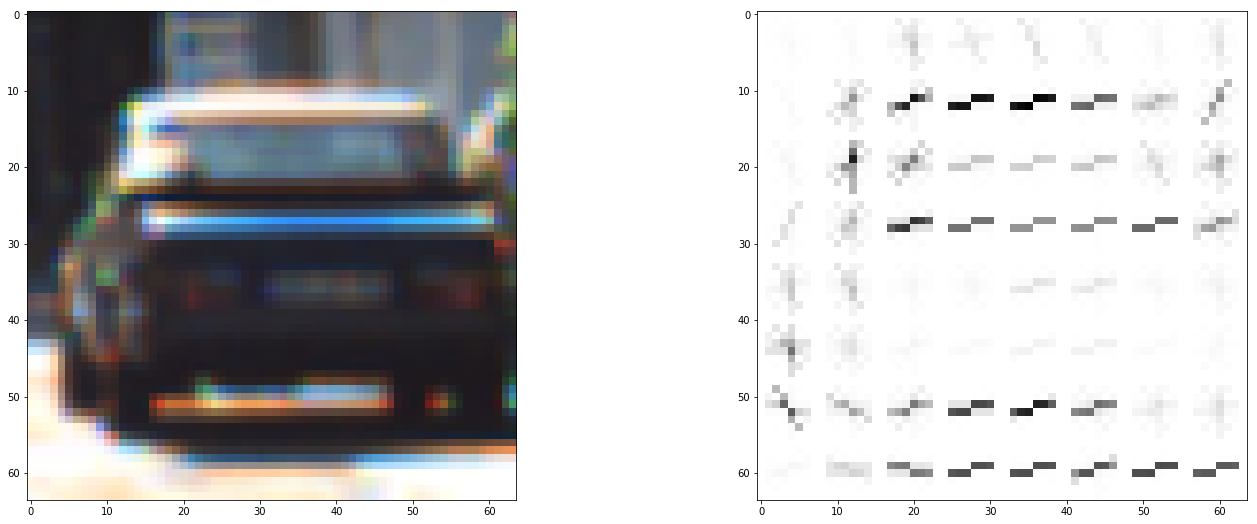

In [3]:
# HOG feature
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
feature_image = cv2.cvtColor(car_example, cv2.COLOR_RGB2YCrCb)
features_car, hog_image_car = get_hog_features(feature_image[:,:,0], orient =9 , pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
%matplotlib inline
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(car_example)
ax2.imshow(hog_image_car, cmap = 'Greys')


/Users/gycelect/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


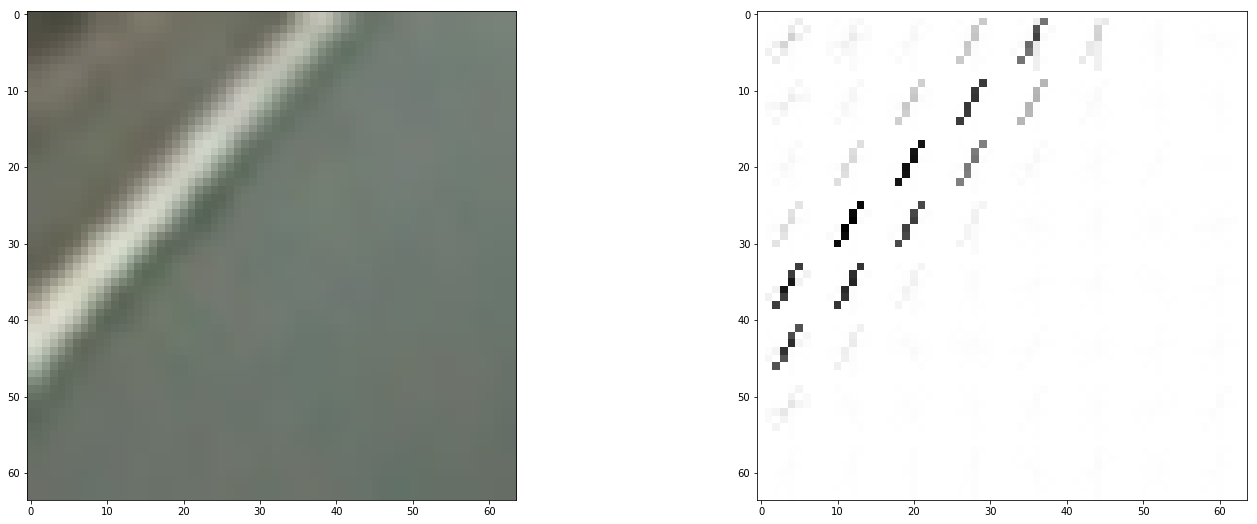

In [4]:
feature_image = cv2.cvtColor(notcar_example, cv2.COLOR_RGB2YCrCb)
features_nocar, hog_image_nocar = get_hog_features(feature_image[:,:,0], orient =9 , pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
%matplotlib inline
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(notcar_example)
ax2.imshow(hog_image_nocar, cmap = 'Greys')

In [19]:
# Train the classifier on the training images
import pickle

# Function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#hog feature function 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

#single image feature extraction
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    

    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                #hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    return np.concatenate(img_features)

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)  #0-1 scale
        feature_img = single_img_features(image, color_space = cspace, spatial_size=spatial_size, 
                                          hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                          cell_per_block=cell_per_block, hog_channel=hog_channel)
        # Append the new feature vector to the features list
        features.append(feature_img)
    # Return list of feature vectors
    return features

cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

# Extract features 
#tunable parameters
cspace = 'YCrCb'
#channel = (0,1,2,'ALL')
hog_channel = 'ALL'
spatial_size = (32,32)
histbin = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
car_features = extract_features(cars, cspace=cspace, spatial_size=spatial_size,
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=cspace, spatial_size=spatial_size,
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,hog_channel=hog_channel)


# Build labels
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial_size,
    'and', histbin,'histogram bins',cspace,'Color space', 
      hog_channel, 'channel for HOG feature')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#clf = GridSearchCV(svc, parameters)
#clf.fit(X_train, y_train)
#print(clf.best_params_)
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')








/Users/gycelect/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using spatial binning of: (32, 32) and 32 histogram bins YCrCb Color space ALL channel for HOG feature
Feature vector length: 8460
22.87 Seconds to train SVC...
Test Accuracy of SVC =  0.9899
My SVC predicts:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 1.]
For these 100 labels:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 1.]
0.00311 Seconds to predict 100 labels with SVC


In [20]:
# save classifer
import pickle
svc_dict = {}
svc_dict['svc'] = svc
svc_dict['scaler'] = X_scaler
svc_dict['orient'] = orient
svc_dict['pix_per_cell'] = pix_per_cell
svc_dict['cell_per_block'] = cell_per_block
svc_dict['spatial_size'] = spatial_size
svc_dict['hist_bins'] = histbin
svc_dict['hog_channel'] = hog_channel
svc_dict['cspace'] = cspace

with open('svc_pickle.p','wb') as f:
    pickle.dump(svc_dict, f)
f.close()
 
#use camera calibration from last project 
with open('calibration.p','rb') as f2:
    camera_calib_dict = pickle.load(f2)
f.close()

mtx = camera_calib_dict['mtx']
dist = camera_calib_dict['dist']

In [104]:
# Define function to find vehicle in images 
import collections 

def undistort(img, mtx, dist):
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_image

def calculate_perspective_transform(img):
    """apply perspective transform"""
    src = np.float32([[600,450],[680,450], [1080, img.shape[0]], [200, img.shape[0]]])
    src = src.reshape((-1,1,2))
    dst = np.float32([[350,0],[1000,0],[1000, img.shape[0]],[350, img.shape[0]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def apply_perspective_transform(img, M):
    img_size = (img.shape[1], img.shape[0])
    img_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return img_warped

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobelmag = np.sqrt(np.sum([np.square(sobelx), np.square(sobely)], axis=0 ))
    scaled_sobel = np.uint8(255*sobelmag/np.max(sobelmag))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def color_mask(hsv,low,high):
    """Return color mask from HSV image"""
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    """Apply color mask to HSV image"""
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

def apply_yellow_white_mask(img, yellow_hsv_low=np.array([ 0, 80, 200]), yellow_hsv_high=np.array([ 40, 255, 255]),
                            white_hsv_low=np.array([  20,   0,   200]), white_hsv_high=np.array([ 255,  80, 255])):
    """Apply yellow white mask to HSV image"""
    image_HSV = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    mask_YW_image = cv2.bitwise_or(mask_yellow,mask_white)
    return mask_YW_image

def hls_select(img, channel='S', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'S':
        channel_img = hls[:,:,2]
    elif channel == 'H':
        channel_img = hls[:,:,0]
    elif channel == 'L':
        channel_img = hls[:,:,1]
    else:
        raise Exception('Ilegal channel')
    binary_output = np.zeros_like(channel_img)
    binary_output[(channel_img > thresh[0]) & (channel_img <= thresh[1])] = 1
    return binary_output

def apply_sobel_filter_on_hls(img, channel='S', sobel_kernel=3, mag_thresh=(0, 255)):
    """apply sobel filter on L and S channel"""
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'S':
        channel_img = hls[:,:,2]
    elif channel == 'L':
        channel_img = hls[:,:,1]
    else:
        raise Exception('Ilegal channel')
    channel_mag_binary = mag_threshold(channel_img, sobel_kernel=sobel_kernel, mag_thresh=mag_thresh)
    return channel_mag_binary

def combine_filters(wrap_img):
    sobel_on_s_binary = apply_sobel_filter_on_hls(wrap_img, mag_thresh= (15,255))
    sobel_on_l_binary = apply_sobel_filter_on_hls(wrap_img, channel='L', mag_thresh= (15,255))
    l_binary = hls_select(wrap_img, channel='L', thresh=(100, 200))
    s_binary = hls_select(wrap_img, channel='S', thresh=(100, 255))
    yw_binary = apply_yellow_white_mask(wrap_img)
    yw_binary[(yw_binary !=0)] = 1
    combined_lsx = np.zeros_like(sobel_on_s_binary)
    combined_lsx[((l_binary == 1) & (s_binary == 1) | (sobel_on_s_binary == 1) |(sobel_on_l_binary == 1)| (yw_binary == 1))] = 1
    return combined_lsx

def apply_smoothing(img, window_size=30, threshold=0.05):
    """apply smoothing in x direction and apply threshold"""
    kernel = np.ones((1, window_size), np.float32) / window_size
    dst = cv2.filter2D(img, -1, kernel)
    img_lane = np.zeros_like(dst)
    img_lane[dst>=threshold] = 1
    return img_lane

def find_line_fit_and_car_offset(img, nwindows=9, margin=100, minpix=50):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    offset = 1/2*(leftx_base + rightx_base) - midpoint
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # to plot
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, out_img, offset

def get_fit_xy(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

def project_back(wrap_img, origin_img, left_fitx, right_fitx, ploty, Minv):
    warp_zero = np.zeros_like(wrap_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = apply_perspective_transform(color_warp, Minv)
    nonzero = newwarp.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_upper = (nonzerox[0],nonzeroy[0])
    left_lower = (min(nonzerox), max(nonzeroy))
    # Combine the result with the original image
    result = cv2.addWeighted(origin_img, 1, newwarp, 0.3, 0)
    return result, left_upper, left_lower

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`(use left lane). The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def detect_lane_from_frame(frame, mtx, dist, M, Minv):
    #undistort
    frame_undistored = undistort(frame, mtx, dist)
    #apply perspective transform
    frame_warped = apply_perspective_transform(frame_undistored, M)
    #apply filter and smoothing
    lane_filtered = combine_filters(frame_warped)
    lane_smoothed = apply_smoothing(lane_filtered)
    #find left lane and right lane
    left_fit, right_fit, out_img, offset_pixel = find_line_fit_and_car_offset(lane_smoothed)
    left_fitx, right_fitx, ploty = get_fit_xy(lane_smoothed, left_fit, right_fit)
    frame_w_lane, left_upper, left_lower = project_back(lane_smoothed, frame, left_fitx, right_fitx, ploty, Minv)
    return frame_w_lane, left_upper, left_lower

    
# Use feature extraction used for training and fitted svc model to predict 
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
              hist_bins, left_upper, left_lower, threshold=0.85):
    right_lower = (img.shape[1], img.shape[0])
    right_upper = (img.shape[1], ystart)
    vertices = np.array([[left_lower, left_upper, right_upper, right_lower]], dtype=np.int32)
    draw_img = np.copy(img)
    img_roi = region_of_interest(img, vertices)
#     plt.imshow(img_roi)
#     plt.show()
    img_roi = img_roi.astype(np.float32)/255
    img_tosearch = img_roi[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HSV')
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            # Use the traine svc to predict 
            #print(sum(test_prediction))
            if svc.predict(test_features) == 1:
            #if svc.decision_function(test_features) > threshold:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #print((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                window_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))      
    return window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold=1):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

#draw boxes on the image
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

#function to average the collected boxes from previous frames
def average_heat_map(heatmap_cache, new_heatmap, num_of_frames_to_keep=3):
    heatmap_cache.append(new_heatmap)
    if len(heatmap_cache) > num_of_frames_to_keep:
        heatmap_cache.popleft()
    elif len(heatmap_cache) == 1:
        return new_heatmap
    averaged_heat_map = np.zeros((new_heatmap.shape[0], new_heatmap.shape[1]), np.float)
    for heat_map in heatmap_cache:
        averaged_heat_map += heat_map /  float(len(heatmap_cache))
    return averaged_heat_map
    


In [37]:
#load the classifier
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]


In [38]:
print(orient)
print(pix_per_cell)
print(cell_per_block)
print(spatial_size)
print(hist_bins)

9
8
2
(32, 32)
32


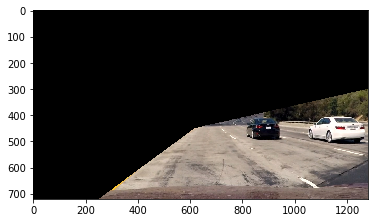

(720, 1280)
2 cars found


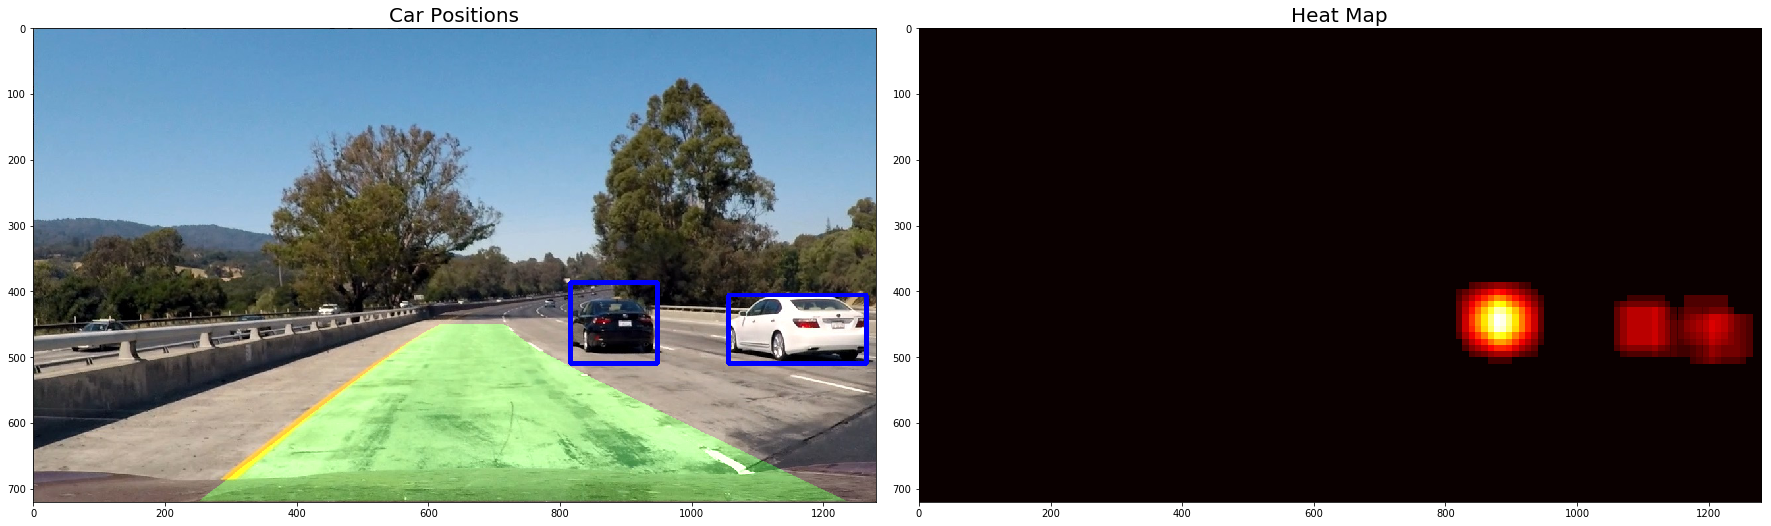

In [100]:
# Test on test image
from scipy.ndimage.measurements import label
image = mpimg.imread('test_images/test1.jpg')
#image = image/255.
ystart = 300
ystop = image.shape[0]
scale = 1.2
#parameters to be load from pickle
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_bins =32
threshold = 0.9
heatmap_threshold = 2
#find cars
M,Minv = calculate_perspective_transform(image)
frame_w_lane, left_upper, left_lower =detect_lane_from_frame(image, mtx, dist, M, Minv)
box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, left_upper, left_lower, threshold)
heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, box_list)
heatmap = apply_threshold(heatmap, threshold=heatmap_threshold)

# Visualize the heatmap when displaying    
heatmap = np.clip(heatmap, 0, 255)
print(heatmap.shape)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(frame_w_lane), labels)
print(labels[1], 'cars found')

#show the heatmap result 
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=20)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(720, 1280, 3)


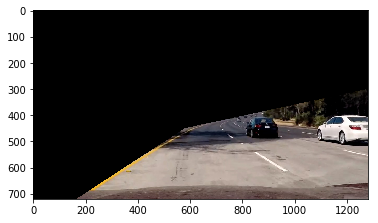

2 cars found


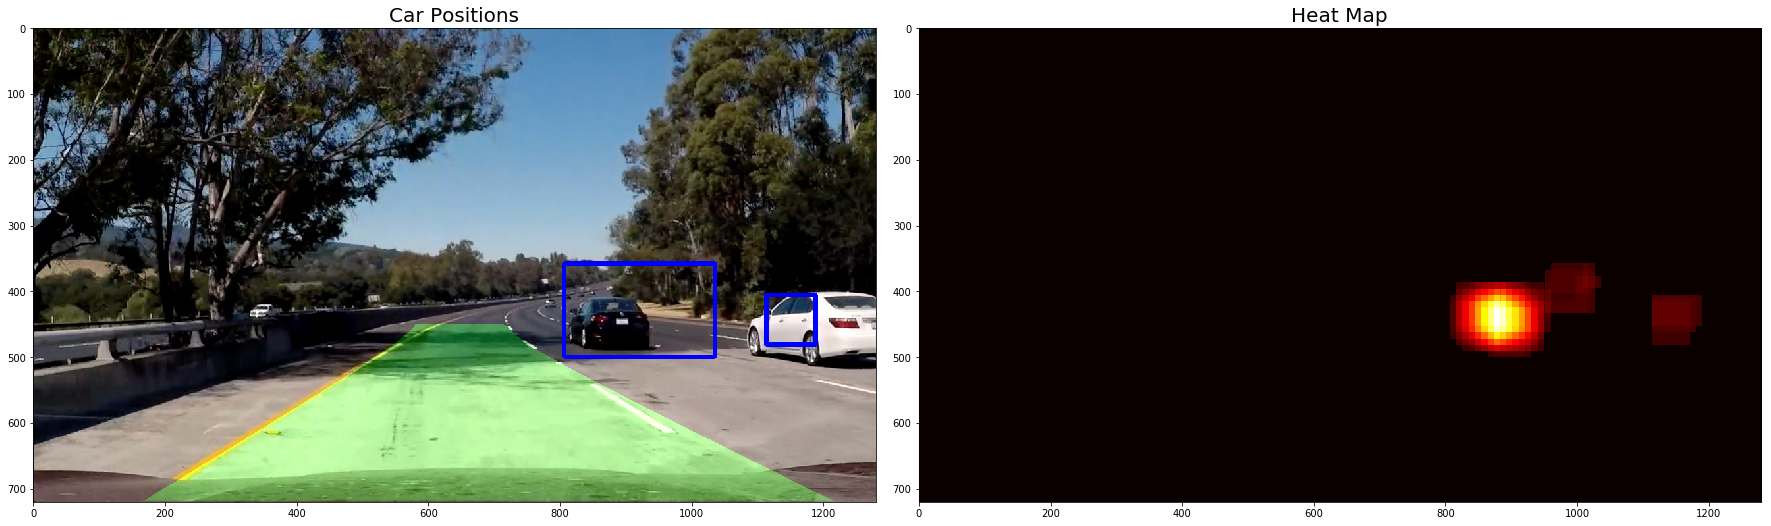

In [99]:
# Test on another image
# Test on test image
from scipy.ndimage.measurements import label
image = mpimg.imread('test_images/test5.jpg')
#image = image/255.
print(image.shape)
threshold = 0.85
heatmap_threshold = 2
#use parameter from training 
frame_w_lane, left_upper, left_lower =detect_lane_from_frame(image, mtx, dist, M, Minv)
box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, left_upper, left_lower, threshold)
heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, box_list)
heatmap = apply_threshold(heatmap, threshold=heatmap_threshold )


# Visualize the heatmap when displaying    
heatmap = np.clip(heatmap, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(frame_w_lane), labels)
print(labels[1], 'cars found')

#show the heatmap result 
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=20)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [105]:
# Test on video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
heatmap_cache = collections.deque()

def vehicle_track(image):
    global mtx
    global dist
    global M
    global Minv
    global heatmap_cache
    #image = image/255.
    ystart = 300
    ystop = 656
    scale = 1.2
    #parameters to be load from pickle
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32,32)
    hist_bins =32
    heat_map_threshold = 2
    num_heat_map_to_keep = 3
    #use parameter from training 
    frame_w_lane, left_upper, left_lower = detect_lane_from_frame(image, mtx, dist, M, Minv)
    box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, left_upper, left_lower)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap,box_list)
    heatmap = apply_threshold(heatmap, threshold=heat_map_threshold)

    # Average heatmap   
    average_heatmap = average_heat_map(heatmap_cache, heatmap, num_of_frames_to_keep=num_heat_map_to_keep)
    average_heatmap = np.clip(average_heatmap, 0, 255)
    average_heatmap = apply_threshold(average_heatmap, threshold=heat_map_threshold)
    # Find final boxes from heatmap using label function
    labels = label(average_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(frame_w_lane), labels)
    return draw_img 

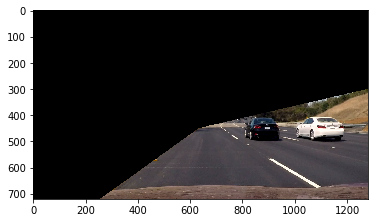

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


  0%|          | 0/39 [00:00<?, ?it/s]

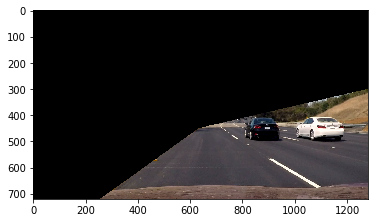

  3%|▎         | 1/39 [00:02<01:52,  2.97s/it]

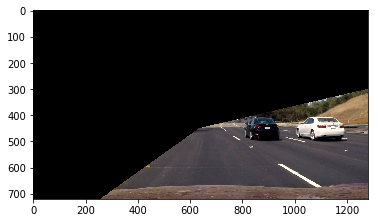

  5%|▌         | 2/39 [00:05<01:50,  2.97s/it]

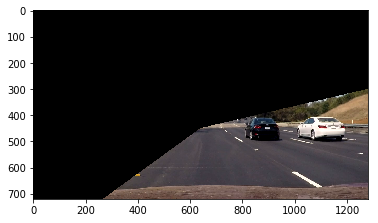

  8%|▊         | 3/39 [00:08<01:47,  2.99s/it]

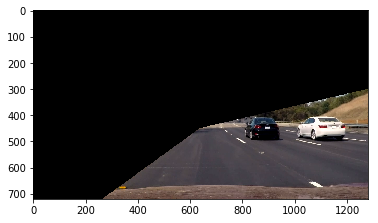

 10%|█         | 4/39 [00:12<01:45,  3.01s/it]

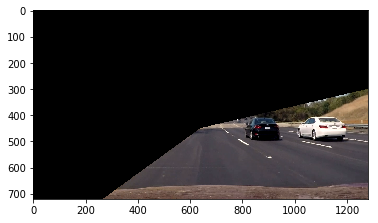

 13%|█▎        | 5/39 [00:15<01:44,  3.07s/it]

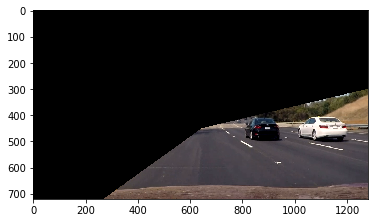

 15%|█▌        | 6/39 [00:18<01:42,  3.11s/it]

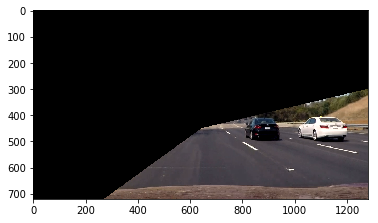

 18%|█▊        | 7/39 [00:21<01:37,  3.05s/it]

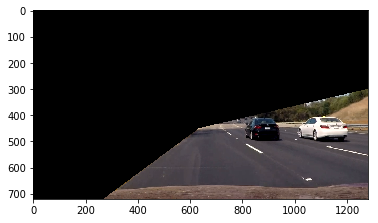

 21%|██        | 8/39 [00:24<01:35,  3.07s/it]

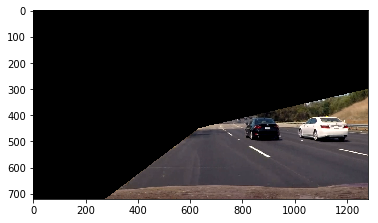

 23%|██▎       | 9/39 [00:27<01:30,  3.01s/it]

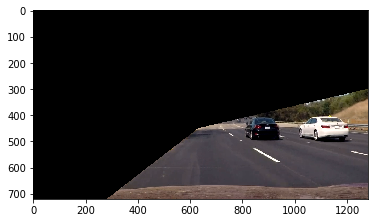

 26%|██▌       | 10/39 [00:30<01:25,  2.96s/it]

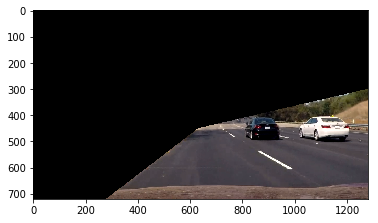

 28%|██▊       | 11/39 [00:33<01:22,  2.96s/it]

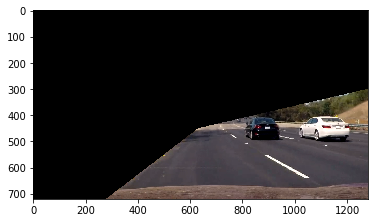

 31%|███       | 12/39 [00:35<01:18,  2.92s/it]

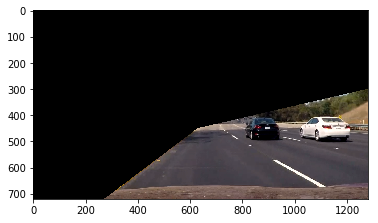

 33%|███▎      | 13/39 [00:39<01:22,  3.15s/it]

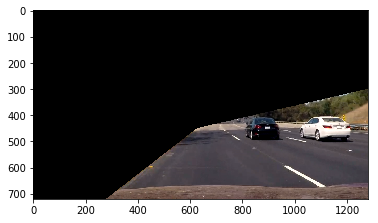

 36%|███▌      | 14/39 [00:42<01:18,  3.13s/it]

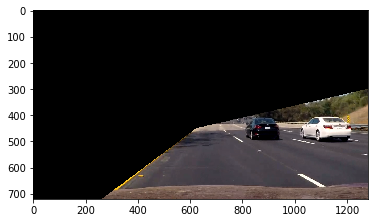

 38%|███▊      | 15/39 [00:45<01:14,  3.09s/it]

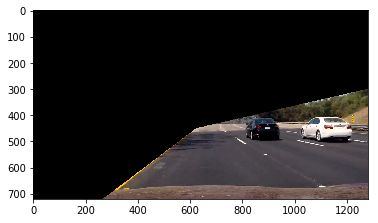

 41%|████      | 16/39 [00:48<01:10,  3.08s/it]

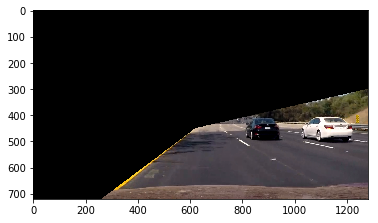

 44%|████▎     | 17/39 [00:51<01:06,  3.02s/it]

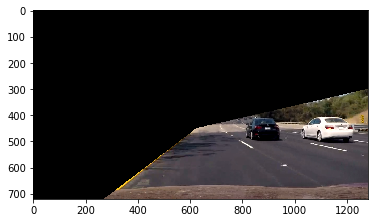

 46%|████▌     | 18/39 [00:54<01:03,  3.00s/it]

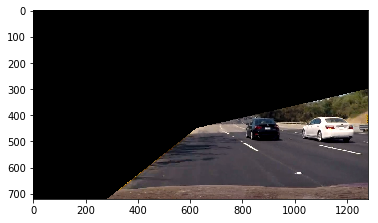

 49%|████▊     | 19/39 [00:57<00:59,  2.97s/it]

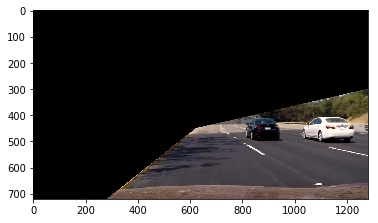

 51%|█████▏    | 20/39 [01:00<00:55,  2.93s/it]

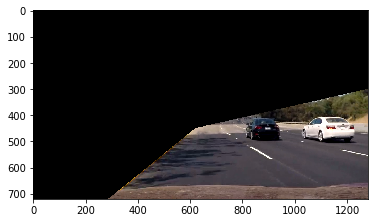

 54%|█████▍    | 21/39 [01:03<00:52,  2.93s/it]

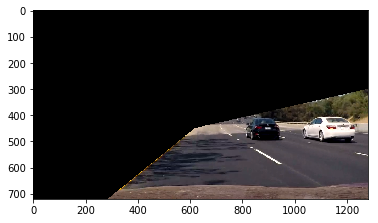

 56%|█████▋    | 22/39 [01:06<00:49,  2.92s/it]

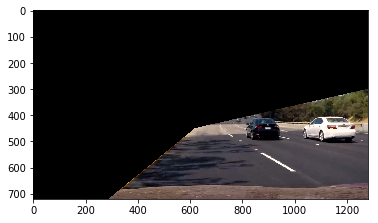

 59%|█████▉    | 23/39 [01:09<00:46,  2.90s/it]

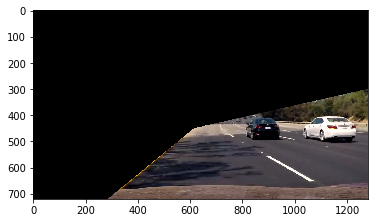

 62%|██████▏   | 24/39 [01:11<00:43,  2.88s/it]

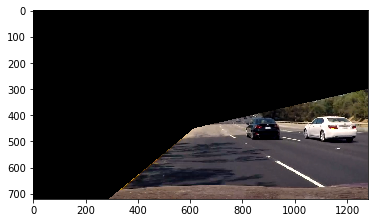

 64%|██████▍   | 25/39 [01:14<00:40,  2.92s/it]

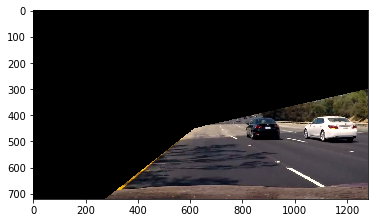

 67%|██████▋   | 26/39 [01:17<00:37,  2.91s/it]

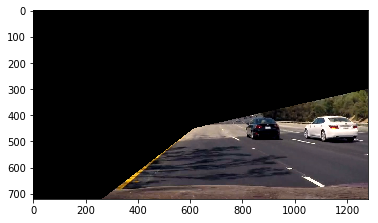

 69%|██████▉   | 27/39 [01:20<00:34,  2.89s/it]

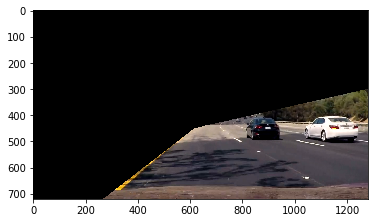

 72%|███████▏  | 28/39 [01:23<00:33,  3.01s/it]

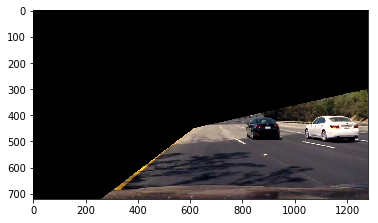

 74%|███████▍  | 29/39 [01:27<00:30,  3.07s/it]

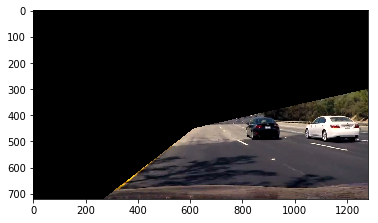

 77%|███████▋  | 30/39 [01:30<00:27,  3.09s/it]

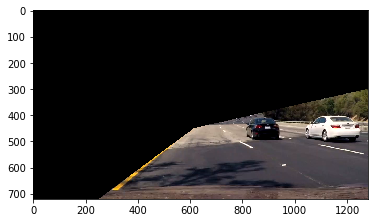

 79%|███████▉  | 31/39 [01:33<00:25,  3.19s/it]

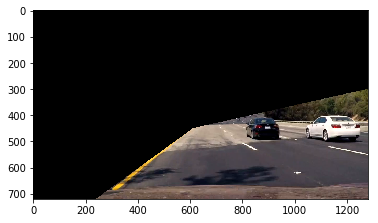

 82%|████████▏ | 32/39 [01:36<00:22,  3.21s/it]

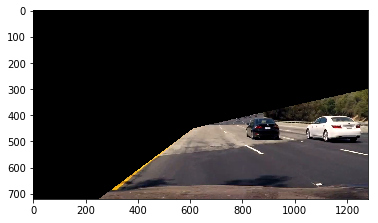

 85%|████████▍ | 33/39 [01:40<00:19,  3.18s/it]

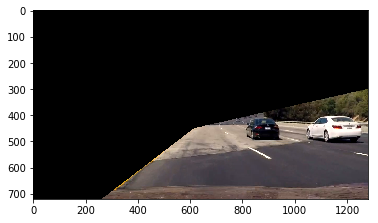

 87%|████████▋ | 34/39 [01:43<00:16,  3.20s/it]

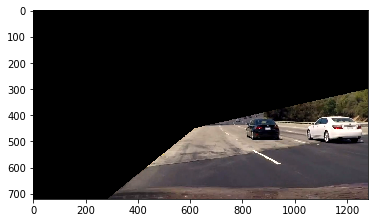

 90%|████████▉ | 35/39 [01:46<00:12,  3.20s/it]

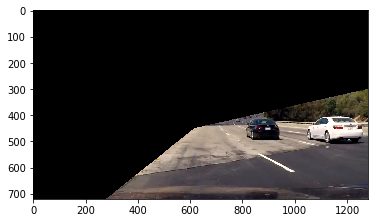

 92%|█████████▏| 36/39 [01:49<00:09,  3.12s/it]

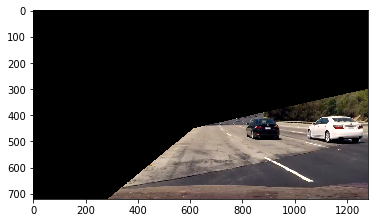

 95%|█████████▍| 37/39 [01:52<00:06,  3.13s/it]

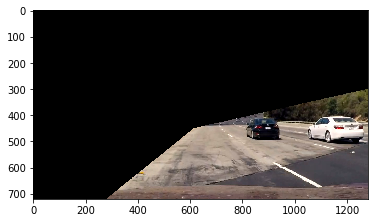

 97%|█████████▋| 38/39 [01:55<00:03,  3.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 1min 53s, sys: 3.95 s, total: 1min 57s
Wall time: 1min 57s


In [102]:

test_output = 'test_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
test_clip = clip1.fl_image(vehicle_track) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

In [103]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [106]:
project_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("project_video.mp4")
project_clip = clip2.fl_image(vehicle_track) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [4:07:35<00:02,  2.95s/it]     


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 59min, sys: 2min 5s, total: 1h 1min 6s
Wall time: 4h 7min 36s


In [107]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))